In [1]:
pip install gymnasium

In [2]:
from time import sleep
import numpy as np
from IPython.display import clear_output
import gymnasium as gym
from gymnasium.envs.registration import register
import torch
from torch import nn
import torch.optim as optim
import torch.nn.functional as F
import math
import matplotlib.pyplot as plt

In [3]:
from google.colab import drive
drive.mount('/gdrive')

Mounted at /gdrive


In [4]:
%cd /gdrive/MyDrive/SP 25/Reinforcement Learning/PPO

/gdrive/MyDrive/SP 25/Reinforcement Learning/PPO


In [16]:
from MiniPacManGym import MiniPacManEnv

register(
    id="MiniPacMan-v0",
    entry_point=MiniPacManEnv,
    max_episode_steps=20
)

env = gym.make("MiniPacMan-v0", render_mode="human", frozen_ghost=True)

/usr/local/lib/python3.11/dist-packages/gymnasium/envs/registration.py:644: UserWarning: WARN: Overriding environment MiniPacMan-v0 already in registry.
  logger.warn(f"Overriding environment {new_spec.id} already in registry.")


In [32]:
class CNN(nn.Module):
  def __init__(self, actions):
    super(CNN, self).__init__()

    self.conv1 = nn.Conv2d(in_channels=1, out_channels=32, kernel_size=3, stride=1, padding=1)
    self.conv2 = nn.Conv2d(in_channels=32, out_channels=64, kernel_size=3, stride=1, padding=1)

    self.fc1 = nn.Linear(6 * 6 * 64, 128)
    self.fc2 = nn.Linear(128, 4)

    self.softmax = nn.Softmax(dim=1)

  def forward(self, x):
    x = F.relu(self.conv1(x))
    x = F.relu(self.conv2(x))
    x = x.view(x.size(0), -1)
    x = F.relu(self.fc1(x))
    x = self.fc2(x)
    x = self.softmax(x)

    return x

In [33]:
pi_network = CNN(4)
optimizer = optim.Adam(pi_network.parameters(), lr=0.001)

In [34]:
M = 100
N = 100
gamma = 0.99
win_array = []

for e in range(M):
    B = []
    wins = 0

    for i in range(N):
        state, info = env.reset()
        done = False
        truncated = False
        trajectory = []

        while not done and not truncated:
            state_tensor = torch.tensor(state, dtype=torch.float32).unsqueeze(0).unsqueeze(0)
            action_probs = pi_network(state_tensor)

            action_probs = torch.clamp(action_probs, min=1e-8)

            action = torch.multinomial(action_probs, 1).item()
            next_state, reward, done, truncated, info = env.step(action)
            log_prob = torch.log(action_probs[0, action])
            trajectory.append((log_prob, reward))
            state = next_state

        if done and reward == 10:
            wins += 1

        rewards = [r for (_, r) in trajectory]
        discounted_rewards = [gamma**t * rewards[t] for t in range(len(rewards))]
        R = sum(discounted_rewards)

        for (log_prob, _) in trajectory:
            B.append(R * log_prob)

    optimizer.zero_grad()
    loss = -torch.mean(torch.stack(B))  # negative average
    loss.backward()
    optimizer.step()

    win_percentage = (wins / N) * 100
    win_array.append(win_percentage)
    print(f"[Update {e+1}/{M}] Win %: {win_percentage:.2f}%")



[Update 1/100] Win %: 0.00%
[Update 2/100] Win %: 1.00%
[Update 3/100] Win %: 3.00%
[Update 4/100] Win %: 2.00%
[Update 5/100] Win %: 5.00%
[Update 6/100] Win %: 7.00%
[Update 7/100] Win %: 14.00%
[Update 8/100] Win %: 15.00%
[Update 9/100] Win %: 12.00%
[Update 10/100] Win %: 20.00%
[Update 11/100] Win %: 21.00%
[Update 12/100] Win %: 13.00%
[Update 13/100] Win %: 15.00%
[Update 14/100] Win %: 16.00%
[Update 15/100] Win %: 24.00%
[Update 16/100] Win %: 19.00%
[Update 17/100] Win %: 23.00%
[Update 18/100] Win %: 19.00%
[Update 19/100] Win %: 26.00%
[Update 20/100] Win %: 27.00%
[Update 21/100] Win %: 36.00%
[Update 22/100] Win %: 24.00%
[Update 23/100] Win %: 40.00%
[Update 24/100] Win %: 30.00%
[Update 25/100] Win %: 42.00%
[Update 26/100] Win %: 48.00%
[Update 27/100] Win %: 43.00%
[Update 28/100] Win %: 52.00%
[Update 29/100] Win %: 62.00%
[Update 30/100] Win %: 53.00%
[Update 31/100] Win %: 60.00%
[Update 32/100] Win %: 70.00%
[Update 33/100] Win %: 64.00%
[Update 34/100] Win %: 67

In [35]:
obs, info = env.reset()
done = False
truncated = False

while not done and not truncated:
    env.render()
    obs=torch.tensor(obs,dtype=torch.float32).unsqueeze(0).unsqueeze(0)
    action_probs = pi_network(obs)
    action = torch.multinomial(action_probs, 1).item()

    obs, reward, done, truncated, info = env.step(action)
    sleep(1)
    clear_output(wait=True)

env.render()
env.close()

xxxxxx
x····x
x··ᗣ·x
x····x
x···◯x
xxxxxx



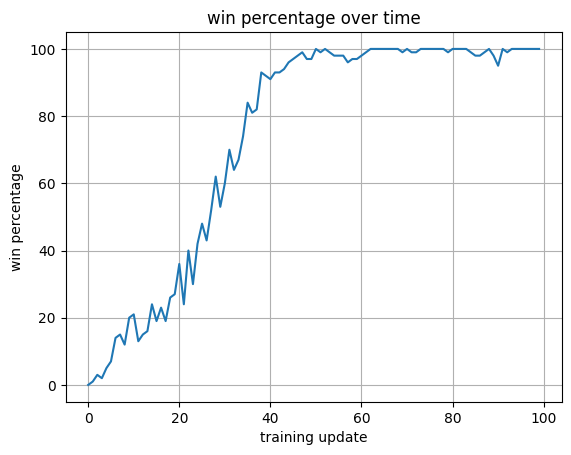

In [36]:
plt.plot(range(M), win_array)
plt.xlabel('training update')
plt.ylabel('win percentage')
plt.title('win percentage over time')
plt.grid()
plt.show()